# Image Classification Train Model

#### Project Url: https://github.com/akshath/image_classification_kit_keras

In [1]:
#---- Install stuff -------
!pip install --upgrade pip

!pip install tensorflow
!pip install numpy==1.19.5

!pip install Pillow
!pip install playsound
!pip install gTTS

!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install pygobject
#pip install pygobject

!pip install PyYAML

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7037 sha256=7f3830c65006af3ddf6a2bbc8ed97c5524e4f80aaf0f2f0571a908b84ef6356a
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


In [2]:
#print system info
import sys
print('Python: ',sys.version)

Python:  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [3]:
is_google_colab = True
is_azure_ml = False

In [4]:
## If you are using the data by mounting the google drive, use the following :
if is_google_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [5]:
#get path for pycode folder 
if is_google_colab:
  !ls '/content/gdrive/MyDrive/ColabNotebooks/' #todo - change me

01-ImageClassificationDataCollector.ipynb  project  test_cpu.ipynb
02-ImageClassificationTrainModel.ipynb	   pycode   tools
03-ImageClassificationTestModel.ipynb	   rl-cab
GestureRecognitionProject.ipynb		   temp


In [6]:
#if .py files are in Google Drive
if is_google_colab:

  import sys
  sys.path.append('/content/gdrive/MyDrive/ColabNotebooks/') #todo - change me

In [7]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import PIL
import zipfile

from PIL import Image

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [10]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [11]:
print('tf version: ',tf.__version__)
print('keras version: ',keras.__version__)

tf version:  2.6.0
keras version:  2.6.0


In [12]:
#check for GPU
#print('tf gpu: ',tf.test.is_gpu_available())
print('tf gpu: ',tf.config.list_physical_devices('GPU'))
for x in tf.config.list_physical_devices():
    print('device: ',x)

tf gpu:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
device:  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
device:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [13]:
import pycode.FileIOUtil
import pycode.TTSUtil
from pycode.ImageClassificationCfg import ImageClassificationCfg
from pycode.RandomColorDistortion import RandomColorDistortion

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


# Read Cfg

In [14]:
import os

In [ ]:
if os.name == 'nt':
    !cd
    !dir
else:
    !pwd
    !ls

/content
gdrive	sample_data


In [15]:
if is_google_colab:
  #locate cfg file in google drive
  !ls '/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/' #change me

cfg.yml  data  flowers-recognition.zip


In [16]:
cfg_file = './project/flowers-recognition/cfg.yml'
#cfg_file = './project/work_pose/cfg.yml'
#cfg_file = './project/home_presence/cfg.yml'

if is_google_colab:
  cfg_file = '/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/cfg.yml' #change me

cfg_file = ImageClassificationCfg(cfg_file)
cfg_file.load()

In [17]:
cfg_file.log_info()

project_name:  flowers-recognition
--------------------
project_parent_dir:  /content/gdrive/MyDrive/ColabNotebooks/project/
project_data_dir:  /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/
temp_dir:  /content/gdrive/MyDrive/ColabNotebooks/temp/
file_ext:  *.jpg
--------------------
reduce_image_wh_by:  3
crop_image_from_left:  0.0
crop_image_from_right:  0.0
--------------------
project_dir:  /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/
project_temp_dir: /content/gdrive/MyDrive/ColabNotebooks/temp/flowers-recognition/
loc_unknown: /content/gdrive/MyDrive/ColabNotebooks/temp/flowers-recognition/non-labeled/
--------------------
labels_from_dir:  True
label count:  5
labels: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [18]:
working_dir_str = cfg_file.project_data_dir

In [19]:
#!ls $working_dir_str
pycode.FileIOUtil.print_dir(working_dir_str, only_dir=True)

/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/daisy
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/dandelion
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/rose
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/sunflower
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/tulip


In [20]:
!ls $working_dir_str

daisy  dandelion  rose	sunflower  tulip


In [26]:
path_to_zip_file = None
#path_to_zip_file = '/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/flowers-recognition.zip'
#path_to_zip_file = '/content/gdrive/MyDrive/ColabNotebooks/work_pose/work_pose.zip'
#path_to_zip_file = '/content/gdrive/MyDrive/ColabNotebooks/home_presence/home_presence.zip'
if path_to_zip_file is not None:
  !ls $path_to_zip_file

In [25]:
if path_to_zip_file is not None:
  #already_extracted = False
  already_extracted = False if len(pycode.FileIOUtil.get_dir(working_dir_str))==0 else True
  print('already_extracted: ',already_extracted)
  if already_extracted==False:  
      with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
          zip_ref.extractall(working_dir_str)

already_extracted:  True


In [ ]:
#run only for flowers data set
#!mv ./project/flowers-recognition/data/flowers/* ./project/flowers-recognition/data/
#!rmdir ./project/flowers-recognition/data/flowers

In [27]:
#!ls $working_dir_str
pycode.FileIOUtil.print_dir(working_dir_str, only_dir=True)

/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/daisy
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/dandelion
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/rose
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/sunflower
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/tulip


In [28]:
if os.name == 'nt':
    !rmdir /Q /S \'$working_dir_str'__MACOSX'\'
else:
    !rm -r $working_dir_str'__MACOSX'

rm: cannot remove '/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/__MACOSX': No such file or directory


In [29]:
rand_seed = 30
np.random.seed(rand_seed)
import random as rn
rn.seed(rand_seed)
tf.random.set_seed(rand_seed)

# Create Data Set

In [30]:
batch_size = 256

color_mode="rgb"
#color_mode="grayscale"

In [31]:
print('working_dir_str: ', working_dir_str)
#!ls $working_dir_str
pycode.FileIOUtil.print_dir(working_dir_str, only_dir=True)

working_dir_str:  /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/daisy
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/dandelion
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/rose
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/sunflower
/content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/data/tulip


In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    working_dir_str, 
    label_mode='categorical',
    batch_size=batch_size, image_size=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width']), 
    shuffle=True, 
    seed=rand_seed, validation_split=0.2, subset='training', color_mode=color_mode
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    working_dir_str, 
    label_mode='categorical',
    batch_size=batch_size, image_size=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width']), 
    shuffle=True, 
    seed=rand_seed, validation_split=0.2, subset='validation', color_mode=color_mode
)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [34]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [35]:
num_classes = len(train_ds.class_names)
num_classes

5

### Visualize the data

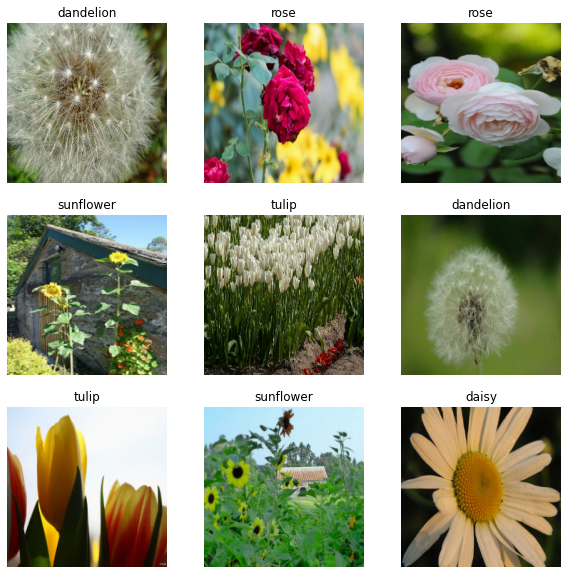

In [36]:
#see few sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3*3):
        ax = plt.subplot(3, 3, i + 1)
        if color_mode=="grayscale":      
            plt.imshow(images[i].numpy().astype("uint8")[:, :, 0], cmap='gray') #
        else:
            plt.imshow(images[i].numpy().astype("uint8"))
        score = tf.nn.softmax(labels[i])
        class_i = np.argmax(score)
        plt.title( class_names[class_i] )
        plt.axis("off")
plt.show()

In [37]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(256, 224, 224, 3)
(256, 5)


In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augumentation

In [39]:
print('input_img_height:',cfg_file.cfg['input_img_height'],)
print('input_img_width:',cfg_file.cfg['input_img_width'])

input_img_height: 224
input_img_width: 224


In [40]:
#reload cfg
#cfg_file.load()

In [41]:
#https://towardsdatascience.com/writing-a-custom-data-augmentation-layer-in-keras-2b53e048a98
randomColorDistortion = RandomColorDistortion()
randomColorDistortion.update_cfg(cfg_file)

data_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(
            tuple(cfg_file.cfg['train_augumentation']['random_rotation']),#(-0.03,0.03), #3% random rotation        
            input_shape=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width'], 1 if color_mode=="grayscale" else 3)), 
        
        layers.experimental.preprocessing.RandomZoom(
            tuple(cfg_file.cfg['train_augumentation']['random_zoom']) #(-0.05,0)  #5% random zoom-in
        ),       
        
        randomColorDistortion,
    ])

if cfg_file.cfg['train_augumentation']['random_flip'] != 'none':
    if cfg_file.cfg['train_augumentation']['random_flip']=='horizontal':
      data_augmentation.add(tf.keras.layers.RandomFlip(mode='horizontal'))
    elif cfg_file.cfg['train_augumentation']['random_flip']=='vertical':
      data_augmentation.add(tf.keras.layers.RandomFlip(mode='vertical'))
    elif cfg_file.cfg['train_augumentation']['random_flip']=='horizontal_and_vertical':
      data_augmentation.add(tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'))
    else:
      print('unknown random_flip value!',cfg_file.cfg['train_augumentation']['random_flip'])

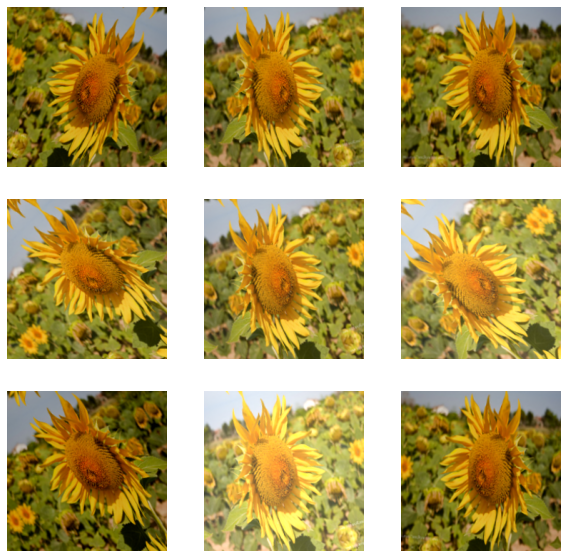

In [42]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    img_index = 1
    for i in range(3*3):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        if color_mode=="grayscale":      
            plt.imshow(augmented_images[img_index].numpy().astype("uint8")[:, :, 0], cmap='gray') #
        else:
            plt.imshow(augmented_images[img_index].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

# Model

In [66]:
#reload cfg
#cfg_file.load()

In [67]:
filepath = cfg_file.cfg['model_file']
print('filepath:',filepath)
print('train_freeze_base_layer: ', cfg_file.cfg['train_freeze_base_layer'])
print('train_freeze_skip_last_layers: ', cfg_file.cfg['train_freeze_skip_last_layers'])

filepath: /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/flowers_recognition_model.h5
train_freeze_base_layer:  True
train_freeze_skip_last_layers:  90


In [68]:
# Callbacks

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=4, cooldown=1) # write the REducelronplateau code here

ES = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode="auto")

callbacks_list = [checkpoint, LR, ES]

In [69]:
#model_to_try = 1 #base cnn
#model_to_try = 2 #transfer learning cnn
model_to_try = cfg_file.cfg['model_to_try']

print('model_to_try: ', model_to_try)

model_to_try:  2


In [70]:
if model_to_try==1:
    #model - bare cnn
    cnn_model = Sequential([
        data_augmentation, 
        #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.experimental.preprocessing.Normalization(), 

        Conv2D(16, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(64, activation='relu'),
        Dropout(0.50),
        BatchNormalization(),

        Dense(64, activation='relu'),
        Dropout(0.50),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')])

In [71]:
try:
  model_base = cfg_file.cfg['model_base']
except KeyError:
  model_base = 'ResNet50V2'

if model_base == 'ResNet50':
  from tensorflow.keras.applications.resnet50 import ResNet50
elif model_base == 'ResNet50V2':
  from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [72]:
#model - transfer learning
if model_to_try==2:
  if model_base == 'ResNet50':
    conv_base = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width'], 1 if color_mode=="grayscale" else 3))
  elif model_base == 'ResNet50V2':
    conv_base = ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width'], 1 if color_mode=="grayscale" else 3))
    
  print(model_base,'layer count',len(conv_base.layers))
  #print existing layers in base model
  #for i in range (len(conv_base.layers)):
  #    print (i,conv_base.layers[i])    

  if cfg_file.cfg['train_freeze_base_layer']:
      # freeze all the weights of the model except the last N layers
      for layer in conv_base.layers[:cfg_file.cfg['train_freeze_skip_last_layers']*-1]:
          layer.trainable = False

  cnn_model = Sequential([
      data_augmentation, 
      #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
      tf.keras.layers.experimental.preprocessing.Normalization(), 
      conv_base, 

      #MaxPooling2D(pool_size=(2, 2)),
      GlobalAveragePooling2D(),
      Flatten(),
      BatchNormalization(),

      #--- vs --
      Dense(8, activation='relu'),
      Dropout(0.60),#50
      BatchNormalization(),
      #--- s --

      #--- s --
      #Dense(256, activation='relu'),
      #Dropout(0.50),#40
      #BatchNormalization(),

      #Dense(128, activation='relu'),
      #Dropout(0.50),#40
      #BatchNormalization(),

      #Dense(64, activation='relu'),
      #Dropout(0.50),#40
      #BatchNormalization(),
      #--- s --

      #--- l --
      #Dense(512, activation='relu'),
      #Dropout(0.60),#40
      #BatchNormalization(),

      #Dense(256, activation='relu'),
      #Dropout(0.60),
      #BatchNormalization(),

      #Dense(128, activation='relu'),
      #Dropout(0.60),
      #BatchNormalization(),

      #Dense(64, activation='relu'),
      #Dropout(0.10),
      #BatchNormalization(),
      #--- l --

      Dense(num_classes, activation='softmax')
      ])

ResNet50V2 layer count 190


In [73]:
lr = 0.0001
optimiser = keras.optimizers.Adam(learning_rate=lr)
cnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (cnn_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_5 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                

In [74]:
### Train the model
epochs = 50
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list,
    initial_epoch = 0
)

Epoch 1/50
14/14 [==============================] - 169s 9s/step - loss: 1.8555 - accuracy: 0.2701 - val_loss: 9.6015 - val_accuracy: 0.2144

Epoch 00001: val_loss improved from inf to 9.60152, saving model to /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/flowers_recognition_model.h5
Epoch 2/50
14/14 [==============================] - 40s 3s/step - loss: 1.6080 - accuracy: 0.3361 - val_loss: 8.7091 - val_accuracy: 0.2074

Epoch 00002: val_loss improved from 9.60152 to 8.70908, saving model to /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/flowers_recognition_model.h5
Epoch 3/50
14/14 [==============================] - 40s 3s/step - loss: 1.5015 - accuracy: 0.3590 - val_loss: 4.2232 - val_accuracy: 0.2317

Epoch 00003: val_loss improved from 8.70908 to 4.22316, saving model to /content/gdrive/MyDrive/ColabNotebooks/project/flowers-recognition/flowers_recognition_model.h5
Epoch 4/50
14/14 [==============================] - 40s 3s/step - loss: 1.43

### Visualizing training results

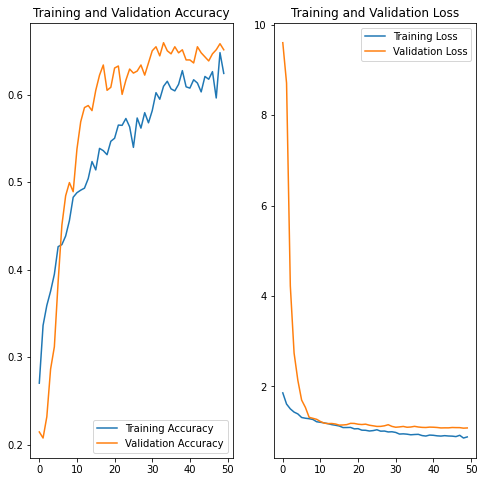

In [75]:
# Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(num_epochs)
epochs_range = range(len(val_acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
pycode.TTSUtil.speak('We got validation accuracy of '+str(round(history.history['val_accuracy'][-1]*100,2)), ipython=True)

In [83]:
!ls $cfg_file.project_dir

cfg.yml  flowers-recognition.json      flowers-recognition.zip
data	 flowers_recognition_model.h5


In [81]:
#save json model file also
from keras.models import model_from_json

model_json = cnn_model.to_json()
#print('model_json: ',model_json)

with open(cfg_file.project_dir+cfg_file.cfg["project_name"]+".json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
#todo add code to see what failed most
#run through val set and log case wise no and accuracy and log image of good and bad